# <center> `Asian Religions Data` </center>

In [7]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import homogeneity_score
import random
import warnings 
from flair.embeddings import WordEmbeddings
import re

from flair.data import Sentence
from nltk.corpus import wordnet
warnings.filterwarnings('ignore')
# Ustawienie ziarna w celu gwarancji reprodukowalności wyników
np.random.seed(123) 

In [8]:
# Algorytmy
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN

In [9]:
# Wczytanie danych
data = pd.read_csv("./AsianReligionsData/AllBooks_baseline_DTM_Labelled.csv")
data.rename({"Unnamed: 0" : "Title"}, axis='columns', inplace=True)

# 1. Funkcje

In [4]:
# Funkcja obliczająca optymalną liczbę klastrów względem miary metric podanej na wejściu
def count_and_plot_k_score(X, model, kmax, metric, attr, subpl):
    assert(attr == 'n_clusters' or attr == 'n_components' or attr == 'none')
    scores = []
    k_range = range(2, kmax+1)
    for k in k_range:
        
        if attr == 'n_clusters':
            M = model(n_clusters = k)
        elif attr == 'n_components':
            M = model(n_components = k)
        else:
            M = model(eps = 5) # Furtka do zrobienia DBSCAN
            
        labels = M.fit_predict(X)
        scores.append(metric(X, labels))
        
    subpl.plot(k_range, scores, 'bx-')
    if metric == davies_bouldin_score:
        subpl.axvline(scores.index(min(scores))+2, color = "red")
    elif metric == calinski_harabasz_score:
        subpl.axvline(scores.index(max(scores))+2, color = "red")
    subpl.set(xlabel='k', ylabel='Score')
    subpl.set_title(model.__name__)

In [5]:
# Funkcja pomocnicza, w celu wywołania powyższej funkcji dla danego na wejściu zbioru i wszystkich algorytmów
def count_and_plot_for_all(X, kmax, metric):
    algorithms = [AgglomerativeClustering, Birch, MiniBatchKMeans, GaussianMixture]
    attr = ['n_clusters', 'n_clusters', 'n_clusters','n_components']

    fig, ax = plt.subplots(2, 2)
    plt.rcParams["figure.figsize"] = (12,6)
    fig.suptitle('Optimal k values for algorithms with regard to '+metric.__name__)
    for i in range(0, len(algorithms)):
        count_and_plot_k_score(X, algorithms[i], kmax, metric, attr[i], ax[i//2, i%2])
    for ax in fig.get_axes():
        ax.label_outer()

In [6]:
# Obliczanie wartości metryk dla klasteryzacji
def cluster_and_score(X, model, k, attr):
    assert(attr == 'n_clusters' or attr == 'n_components')
    
    if attr == 'n_clusters':
        M = model(n_clusters = k)
    else:
        M = model(n_components = k)
        
    X['k'] = M.fit_predict(X)
    cal_har = calinski_harabasz_score(X, X['k'])
    dav_bou = davies_bouldin_score(X, X['k'])
    d = { 'Model': [model.__name__],
         'Indeks Calińskiego-Harabasza': [cal_har],
         'Indeks Daviesa–Bouldina': [dav_bou]}
    df = pd.DataFrame(data=d)
    df.set_index('Model', inplace = True)
    return df, X

In [7]:
# Wizualizacja przypisania do klastrów
def plot_clusters(X):
    sns.pairplot(X, height=4, hue='k', palette = 'dark')
    plt.tight_layout()
    plt.show()

In [8]:
# Czynności czyszczące przygotowane na potrzeby poprzedniego etapu prac zamknięte w funkcji.
def deep_cleanse():
    global data
    def forms(word):
        formlist = []
        for x in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
            mo = wordnet.morphy(word, x)
            if not mo is None:
                formlist.append(mo)
        if formlist==[]:
            return None
        else:
            return sorted(formlist, key=len)
    def groups(words):
        groupsL = []
        i = 0
        j = 0
        mainword = []
        while j < len(words):
            if not re.findall('^' + words[i], words[j]) == []:
                mainword.append(words[j])
                j = j + 1
            else:
                groupsL.append(mainword)
                mainword = []
                i = j
        return groupsL
    def merge_cols(suffix):
        global data
        S = len(suffix)
        for W in words:
            if W[-S:]==suffix:
                W2 = W[:-S]
                W3 = W2+"e"
                if W2 in data.columns and not W2 in ["book", "form"]:
                    data[W2]=data[W2]+data[W]
                    data=data.drop(columns=[W])
                elif W3 in data.columns:
                    data[W3]=data[W3]+data[W]
                    data=data.drop(columns=[W])
    
    data=data.drop(columns=['TRUE', 'FALSE'])
    words=data.columns
    for W in words:
        if len(W)%2==0:
            W2 = W[0:len(W)//2]
            if W==W2*2 and W2 in data.columns:
                data[W2]=data[W2]+2*data[W]
                data = data.drop(columns=[W])
    words=data.columns
    for W in words:
        if len(W)>13 and forms(W) is None:
            W2 = W[:-13]
            if W2 in data.columns and W[-13:]=='consciousness':
                data[W2]=data[W2]+data[W]
                data['consciousness']=data['consciousness']+data[W]
                data=data.drop(columns=[W])
    words=data.columns
    data['nor']=0
    for W in words:
        if not re.search('neither.*nor.*', W) is None:
            m = re.search('neither(.*)nor(.*)', W)
            W1 = m.group(1)
            W2 = m.group(2)
            if not W1 in data.columns:
                data[W1] = 0
            if not W2 in data.columns:
                data[W2] = 0
            data['neither']=data['neither']+data[W]
            data['nor']=data['nor']+data[W]
            data[W1]=data[W1]+data[W]
            data[W2]=data[W2]+data[W]
            data=data.drop(columns=[W])
    words = list(data.columns)
    words.remove("sittest")

    for W in words:
        if forms(W) is None and len(W)>=6:
            L = len(W)
            cand = []
            for p in range(3, L-2):
                if W[:p] in data.columns and W[p:] in data.columns:
                    cand.append(p)
            if len(cand)==1:
                p = cand[0]
                data[W[:p]]=data[W[:p]]+data[W]
                data[W[p:]]=data[W[p:]]+data[W]
                data=data.drop(columns=[W])
    words = list(data.columns)
    words.remove("book")
    for W in words:
        F=forms(W)
        # funkcję forms napisana tak, by na początku listy zawsze dawała najkrótsze słowo
        if not F is None:
            W1=F[0]
            if W1=="book":
                # book to inna kolumna
                W1="books"
            if not W1==W:
                if not W1 in data.columns:
                    data[W1]=data[W]
                else:
                    data[W1]=data[W1]+data[W]
                data = data.drop(columns=[W])
    words = list(data.columns)
    for W in words:
        if len(W)>3 and forms(W) is None:
            if W[-3:] in ["eth", "est"] and not (forms(W[:-3]) is None and forms(W[:-2]) is None):
                if not forms(W[:-3]) is None:
                    W2=W[:-3]
                elif not forms(W[:-2]) is None:
                    W2=W[:-2]
                if W2 in data.columns:
                    data[W2]=data[W2]+data[W]
                else:
                    data[W2]=data[W]
                data=data.drop(columns=[W])
    words=data.columns
    for W in words:
        if len(W)>2 and forms(W) is None:
            if W[-2:]=="st" and not forms(W[:-2]) is None:
                W2=W[:-2]
                if W2 in data.columns:
                    data[W2]=data[W2]+data[W]
                else:
                    data[W2]=data[W]
                data=data.drop(columns=[W])
    words=data.columns
    for W in words:
        if len(W)>4 and forms(W) is None:
            if W[-4:]=="ieth" and W[:-4]+"y" in data.columns:
                W2=W[:-4]+"y"
                if W2 in data.columns:
                    data[W2]=data[W2]+data[W]
                    data=data.drop(columns=[W])
    words = data.columns
    for W in words:
        if len(W)>5 and forms(W) is None:
            if W[-3:] in ["eth", "est"] and not forms(W[:-4]) is None and W[-5]==W[-4]:
                W2=W[:-4]
                if W2 in data.columns:
                    data[W2]=data[W2]+data[W]
                else:
                    data[W2]=data[W]
                data=data.drop(columns=[W])
    data.oil = data.oil + data.oilofthejoints
    data.joint = data.joint + data.oilofthejoints
    data.between = data.betweenthetwo
    data.two = data.two + data.betweenthetwo
    data.respond = data.respond + data.respondedthe
    data.the = data.the + data.oilofthejoints + data.betweenthetwo + data.respondedthe
    data = data.drop(columns=["oilofthejoints", "betweenthetwo", "respondedthe"])
    data.cling = data.cling + 2*data.clingingclingingsustenance
    data.sustenance = data.sustenance + data.clingingclingingsustenance
    data.deceitful = data.deceitful + data.deceitfnl
    data = data.drop(columns=["clingingclingingsustenance", "deceitfnl"])
    L = ["hood", "ation", "ate", "ment", "al", "ion", "st", "s", "ed", "ative",
         "ic", "ance", "ant", "ness", "ful", "er", "ry", "ous", "ive",
        "able", "ity", "ship", "th", "ism"]
    for L2 in L:
        merge_cols(L2)

In [9]:
deep_cleanse()

# 2. Embeddingi 

In [10]:
# Przygotowanie słownika zawierający embeddingi dla każdego słowa występującego w wyczyszczonej ramce danych. 
def embed_crate(df,embedding):
    
    res = dict()
    embedding 
    for i in df.columns:
       
        sentence = Sentence(i)
        embedding.embed(sentence)
        res[i]=sentence[0].embedding
    return res    
        

In [11]:
embed_dict = embed_crate(data,WordEmbeddings('glove'))

In [12]:
len(embed_dict['god']) # 100-wymiarowe embeddingi słów 

100

## 2.1. Ramka 1 
Dla każdego słowa przypisywana jest waga, a następnie przygotowane embeddingi zostają wysumowane. 


In [13]:
def df_1_c(data,embed_dict):
    chapters = data.Title
    values = [0]* 590
    for i in range(len(data)):
        for j in range(1,len(data.iloc[i,:])):
        
            values[i]=values[i]+data.iloc[i,j]*embed_dict[data.columns[j]]
    
    return pd.DataFrame(dict(zip(chapters,values))).T

In [14]:
df_1 = df_1_c(data,embed_dict)


## 2.2. Ramka 2 
Analogicznie ale tym razem wagi będą zlogarytmizowane.

In [15]:
import math 
def df_2_c(data,embed_dict):
    chapters = data.Title
    values = [0]* 590
    for i in range(len(data)):
        for j in range(1,len(data.iloc[i,:])):
            if data.iloc[i,j] > 0:
                values[i]=values[i]+math.log(data.iloc[i,j])*embed_dict[data.columns[j]]
    
    return pd.DataFrame(dict(zip(chapters,values))).T

In [16]:
df_2 = df_2_c(data,embed_dict)

## 2.3. Ramka 3 
Teraz waga będzie deiniowana jako stosunek ilości wystąpień danego słowa do ilości wszyskich słów w rozdziale.

In [17]:
def df_3_c(data,embed_dict):
    chapters = data.Title
    values = [0]* 590
    total_number_of_words =[0]*590
    
    for i in range(len(data)):
        total_number_of_words[i]= sum(data.drop('Title',axis=1).iloc[i,:])
            
    
    for i in range(len(data)):
        for j in range(1,len(data.iloc[i,:])):
            if data.iloc[i,j] > 0:
                values[i]=values[i]+(data.iloc[i,j]/total_number_of_words[i])*embed_dict[data.columns[j]]
    
    return pd.DataFrame(dict(zip(chapters,values))).T

In [18]:
df_3 = df_3_c(data,embed_dict)

In [19]:
df_3

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Buddhism_Ch1,-0.022530,0.097951,0.188909,-0.047922,-0.245187,0.354164,-0.307341,0.039245,0.053534,-0.032635,...,-0.240950,-0.215728,-0.011539,0.153970,0.032619,0.072832,-0.021422,-0.459357,0.228165,0.071372
Buddhism_Ch2,-0.108575,0.199216,0.026547,0.096495,-0.106579,0.263910,-0.180148,-0.068481,-0.067385,-0.034111,...,-0.163655,-0.133964,-0.000227,0.081301,-0.220052,-0.182085,-0.129820,-0.329938,0.266191,0.225836
Buddhism_Ch3,-0.171875,0.174061,0.109477,0.039512,-0.440252,0.139288,-0.298671,-0.122135,-0.072928,-0.038563,...,-0.294830,-0.140158,-0.093778,0.186818,-0.103826,0.024581,0.053405,-0.430103,0.409881,0.186195
Buddhism_Ch4,0.021673,0.094724,0.140649,0.152324,-0.175798,0.100292,-0.161001,-0.206929,-0.004896,0.052388,...,-0.279083,-0.103580,-0.072146,0.204478,-0.278195,-0.076079,-0.251690,-0.466920,0.180346,0.146465
Buddhism_Ch5,-0.161681,0.144457,0.010763,0.057393,-0.420007,0.157399,-0.372674,-0.037783,-0.356639,0.097980,...,-0.371834,0.035996,0.033633,0.107379,0.194585,0.067486,0.063206,-0.396410,0.141051,0.136061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BookOfWisdom_Ch15,-0.034779,0.284344,0.278747,-0.194930,-0.166330,0.300388,-0.246836,-0.081652,0.103750,-0.075068,...,-0.008146,-0.149313,0.178117,0.106502,-0.190361,-0.166071,-0.199298,-0.370165,0.151548,0.086154
BookOfWisdom_Ch16,-0.093602,0.244173,0.238242,-0.202266,-0.170910,0.240306,-0.217727,-0.012255,0.097858,-0.033522,...,-0.014605,-0.164638,0.064116,0.058652,-0.359597,-0.255642,-0.132853,-0.222056,0.179595,0.121415
BookOfWisdom_Ch17,-0.059999,0.206287,0.330016,-0.208128,-0.150904,0.258515,-0.278898,-0.043372,0.045771,-0.172303,...,-0.007375,-0.148168,-0.016384,0.064334,-0.330636,-0.069240,-0.127153,-0.164539,0.218558,0.076764
BookOfWisdom_Ch18,0.028144,0.220991,0.235412,-0.133945,-0.135893,0.322014,-0.278993,-0.036589,0.022789,-0.040955,...,-0.022724,-0.169135,0.126561,0.066848,-0.332724,-0.161418,-0.176398,-0.248876,0.162016,0.052545


## 2.4. Ramka 4 
Najprostszy sposób, oparty na obecności słowa w rozdziale.

In [20]:
def df_4_c(data,embed_dict):
    chapters = data.Title
    values = [0]* 590
    for i in range(len(data)):
        for j in range(1,len(data.iloc[i,:])):
            if data.iloc[i,j] > 0:
                values[i]=values[i]+embed_dict[data.columns[j]]
    
    return pd.DataFrame(dict(zip(chapters,values))).T

In [21]:
df_4 = df_4_c(data,embed_dict)

# 3. Rozważenie możliwych kombinacji embedding-model z uwzględnieniem wart. indeksów Daviesa-Bouldina i Calińskiego-Harabasza dla różnych k

Wyboru optymalnej kombinacji dokonamy w oparciu o wartości indeksów Calińskiego-Harabasza i Daviesa-Bouldina obliczonych dla poszczególnych par embedding-model.

In [22]:
# Porzucenie informacji o przynależności do rozdziałów
df_1.reset_index(drop=True, inplace=True)
df_2.reset_index(drop=True, inplace=True)
df_3.reset_index(drop=True, inplace=True)
df_4.reset_index(drop=True, inplace=True)

## 3.1. Embedding 1.

### Indeks Daviesa-Bouldina 

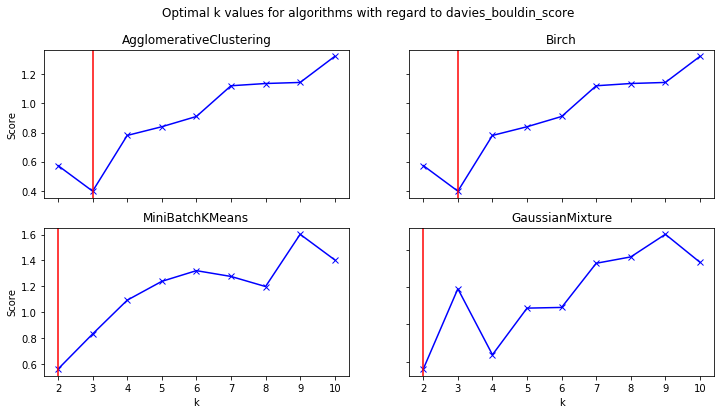

In [253]:
count_and_plot_for_all(df_1, 10, davies_bouldin_score)

### Indeks Calińskiego-Harabasza

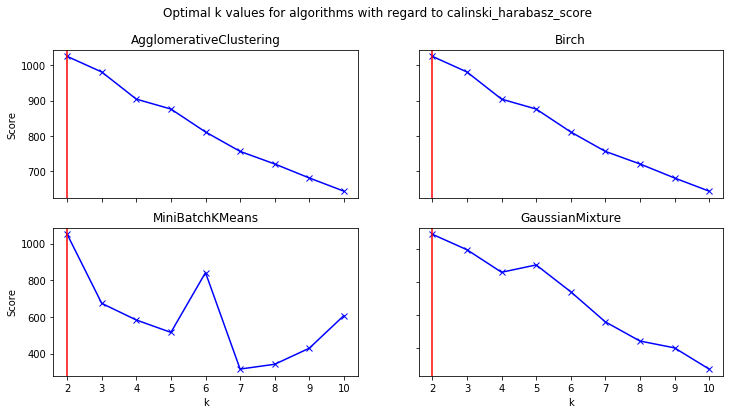

In [32]:
count_and_plot_for_all(df_1, 10, calinski_harabasz_score)

## 3.2 Embedding 2

### Indeks Daviesa-Bouldina 

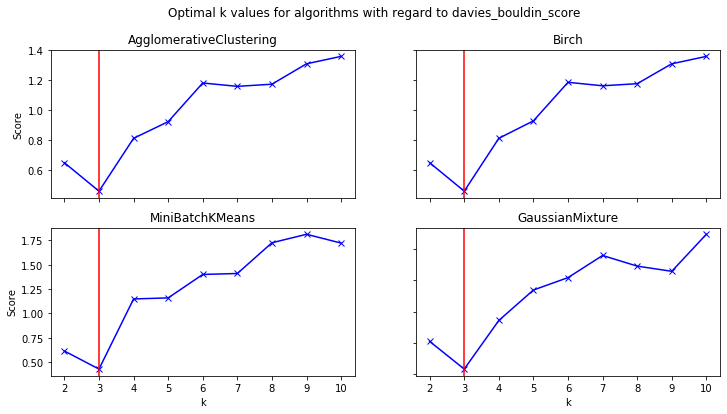

In [33]:
count_and_plot_for_all(df_2, 10, davies_bouldin_score)

### Indeks Calińskiego-Harabasza

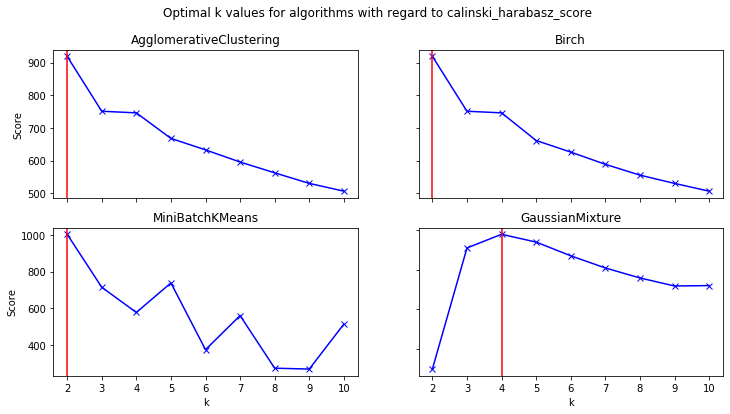

In [34]:
count_and_plot_for_all(df_2, 10, calinski_harabasz_score)

## 3.3. Embedding 3

### Indeks Daviesa-Bouldina 

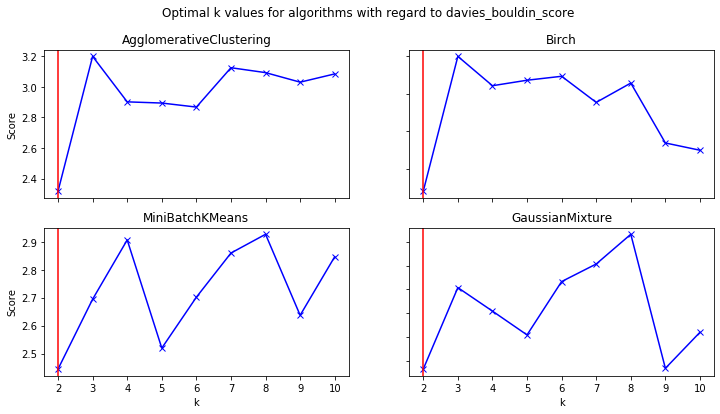

In [35]:
count_and_plot_for_all(df_3, 10, davies_bouldin_score)

### Indeks Calińskiego-Harabasza

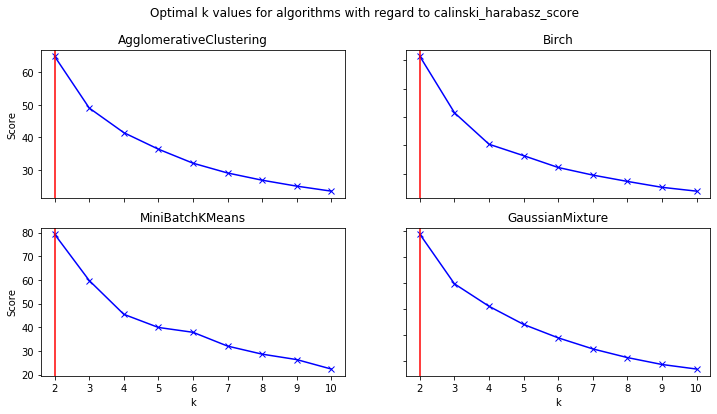

In [36]:
count_and_plot_for_all(df_3, 10, calinski_harabasz_score)

## 3.4. Embedding 4

### Indeks Daviesa-Bouldina 

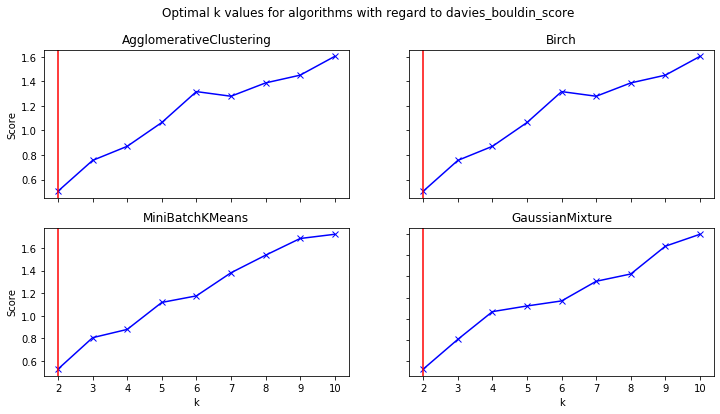

In [37]:
count_and_plot_for_all(df_4, 10, davies_bouldin_score)

### Indeks Calińskiego-Harabasza

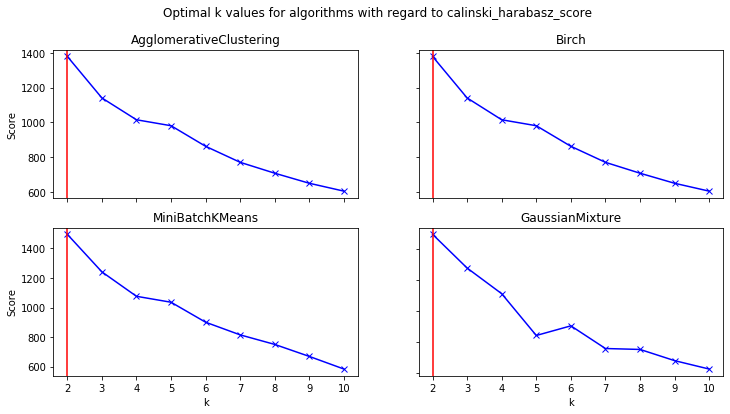

In [38]:
count_and_plot_for_all(df_4, 10, calinski_harabasz_score)

## Ogólny wniosek:

Dla każdego z powyższych embeddingów wyniki względem wybranych miar nie są zadowalające, nie mniej jednak najlepsze okazały się pierwszy i czwarty. Dlatego w dalszych rozważaniach postanowiliśmy uwzględnić tylko te.  
Szansę na poprawienie rezultatów względem rozważanych indeksów upatrujemy w procesie redukcji wymiarów, dlatego na powyższych danych przeprowadzimy zarówno PCA, jak i t-SNE.

# 4. Redukcja wymiarów 
Funkcje wykonujące przekształcenia dla PCA i TNSE.

## 4.1. PCA

In [23]:
# PCA  funkcja do tworzenia ramek 
from sklearn.decomposition import PCA

def PCA_for_df (df,n_component):
    pca = PCA(n_components=n_component)
    df_no_title=pca.fit_transform(df)
    df_return=pd.DataFrame(df_no_title).set_index(df.index)
    return df_return

## 4.1.1. Realizacja analizy głównych składowych na wybranych embeddingach

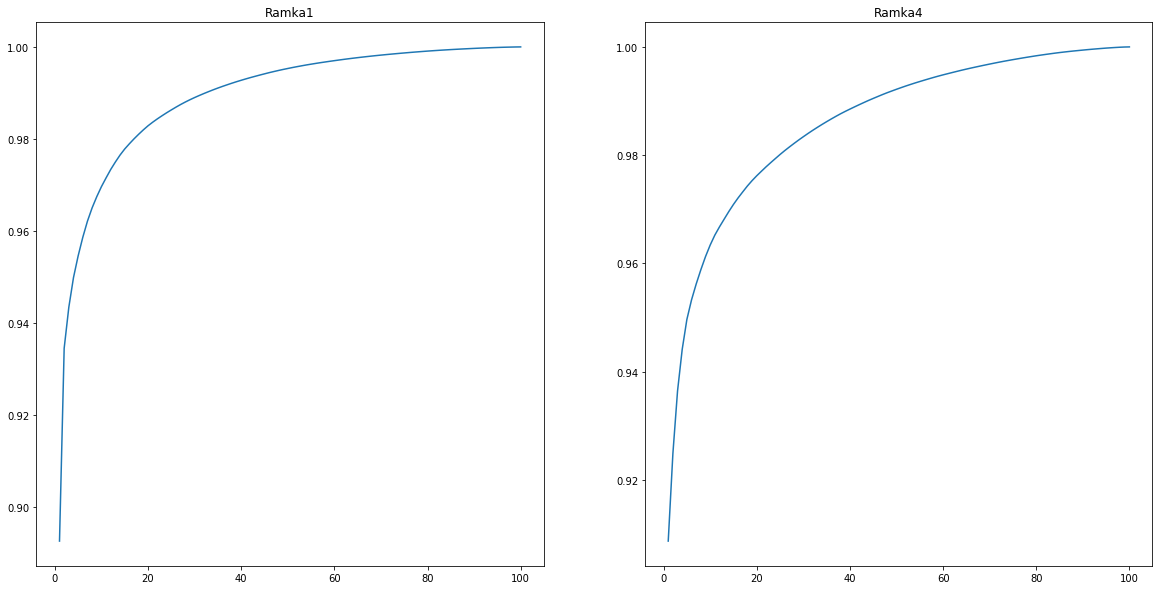

In [24]:
# Od tego momentu nasze dane to te uzyskane w wyniku przeprowadzenia pierwszego i czwartego embeddingu, 
# a następnie redukcji t-SNE

pca1 = PCA().fit(df_1)
pca4 = PCA().fit(df_4)

plt.rcParams["figure.figsize"] = (20,10)
fig, ax =plt.subplots(1,2)
sns.lineplot(range(1, len(pca1.explained_variance_ratio_)+1), np.cumsum(pca1.explained_variance_ratio_), ax=ax[0]).set_title('Ramka1')
sns.lineplot(range(1, len(pca4.explained_variance_ratio_)+1), np.cumsum(pca4.explained_variance_ratio_), ax=ax[1]).set_title('Ramka4')
fig.show()

Liczba komponentów:

- Około 20 dla Ramki 1.
- Około 40 Ramki 4

In [25]:
df1_p = PCA_for_df(df_1, 20)
df4_p = PCA_for_df(df_4, 40)

## 4.1.2. Ponowne rozważenie możliwych kombinacji embedding-model, analogiczne j.w.

### 4.1.2.1. ... dla pierwszego embeddingu

### Indeks Daviesa-Bouldina

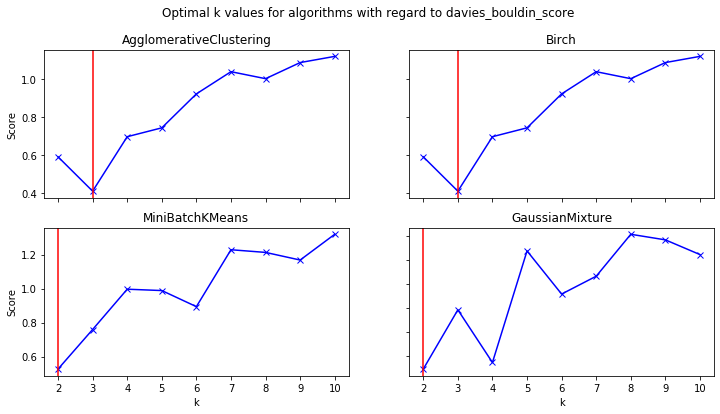

In [45]:
count_and_plot_for_all(df1_p, 10, davies_bouldin_score)

### Indeks Calińskiego-Harabasza

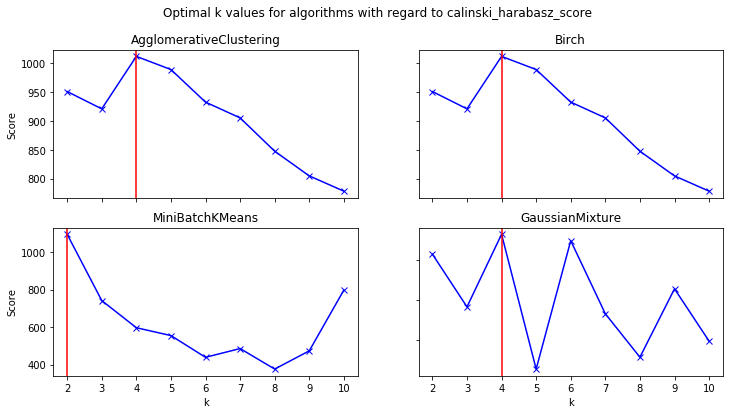

In [46]:
count_and_plot_for_all(df1_p, 10, calinski_harabasz_score)

### 4.1.2.1. ... dla czwartego embeddingu

### Indeks Daviesa-Bouldina

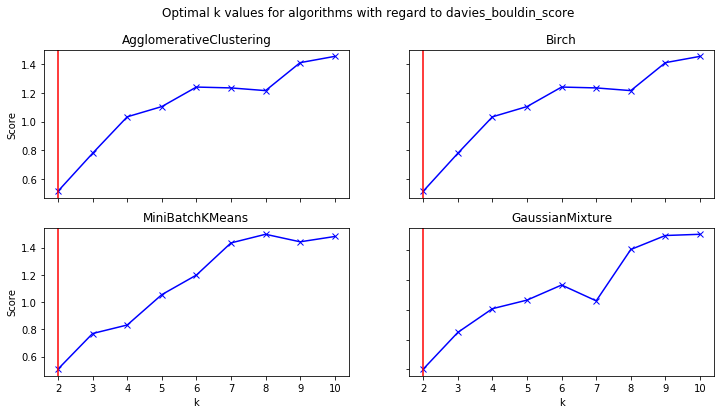

In [47]:
count_and_plot_for_all(df4_p, 10, davies_bouldin_score)

### Indeks Calińskiego-Harabasza

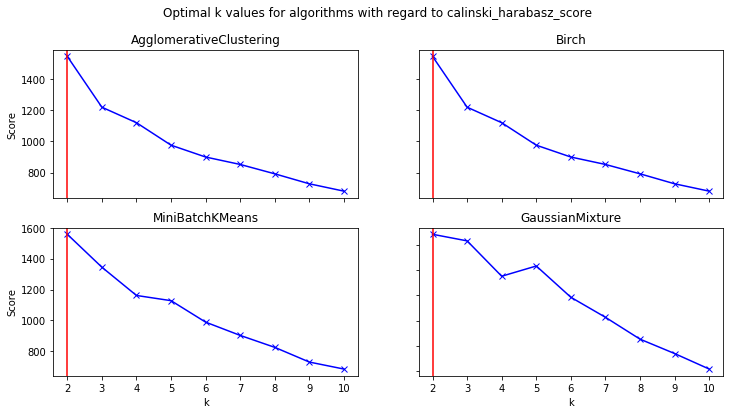

In [48]:
count_and_plot_for_all(df4_p, 10, calinski_harabasz_score)

## Wnioski:
Względem indeksu Calińskiego-Harabasza najlepszym embeddingiem okazuje się czwarty, natomiast względem indeksu Daviesa-Bouldina pierwszy.  
Przy czym nawet dla optymalnych par, uzyskane rezultaty nie są zadowalające. Dlatego w dalszej analizie postanowiliśmy rozważyć inną metodę redukcji wymiarów, mianowicie t-SNE.

## 4.2. t-SNE

In [26]:
from sklearn.manifold import TSNE

def TSNE_for_df(df,random_state=123):
    tSNE = TSNE(random_state=random_state)
    df_no_title=tSNE.fit_transform(df)
    df_return=pd.DataFrame(df_no_title).set_index(df.index)
    return df_return

## 4.2.1. Realizacja redukcji t-SNE na wybranych embeddingach

In [27]:
df1_t = TSNE_for_df(df_1)
df4_t = TSNE_for_df(df_4)

## 4.2.2. Ponowne rozważenie możliwych kombinacji embedding-model, analogiczne j.w.

### 4.2.2.1. ... dla pierwszego embeddingu

### Indeks Daviesa-Bouldina

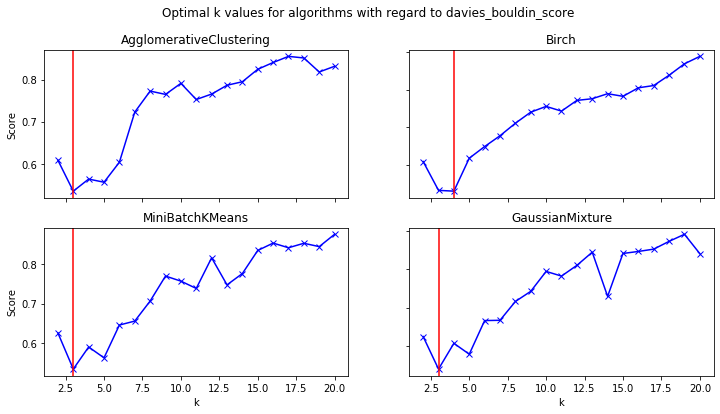

In [51]:
count_and_plot_for_all(df1_t, 20, davies_bouldin_score)

### Indeks Calińskiego-Harabasza

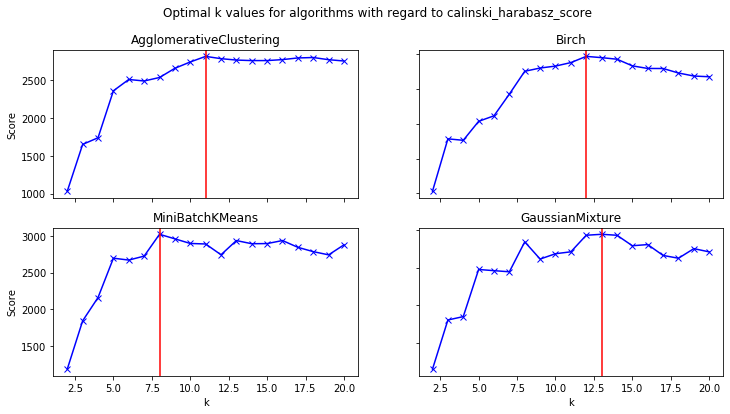

In [64]:
count_and_plot_for_all(df1_t, 20, calinski_harabasz_score)

### 4.2.2.2. ... dla czwartego embeddingu

### Indeks Daviesa-Bouldina

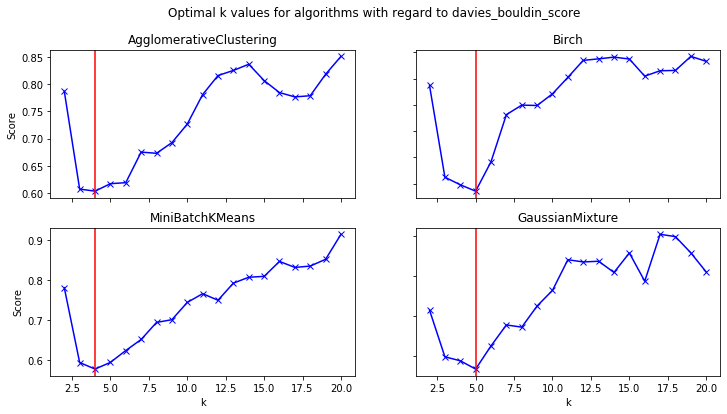

In [53]:
count_and_plot_for_all(df4_t, 20, davies_bouldin_score)

### Indeks Calińskiego-Harabasza

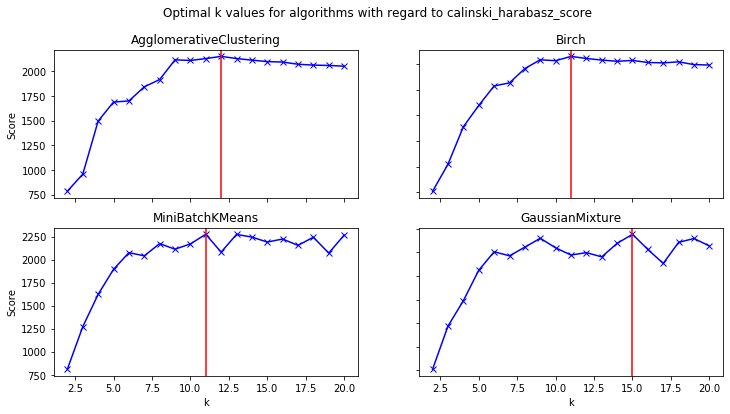

In [57]:
count_and_plot_for_all(df4_t, 20, calinski_harabasz_score)

##  Wnioski:
W wyniku zmiany metody redukcji wymiarów wyniki względem indeksu Calińskiego-Harabasza znacznie się poprawiły, natomiast względem indeksu Daviesa-Bouldina uległy pogorszeniu. Globalnie najlepsze rezultaty względem pierwszej z rozważanych miar uzyskano dla embeddingu 1. i redukcji PCA, natomiast względem drugiej dla tego samego embeddingu i redukcji t-SNE. 


W ogólności optymalny względem rozważanych miar okazał się zatem embedding 1. Przy czym na podstawie powyższych rezultatów, z braku możliwości odczytania dokładnych wartości miar, nie jesteśmy w stanie jednoznacznie wyłonić algorytmu i ilości skupień, które dla tego embeddingu byłyby globalnie najlepsze. Z tego powodu, w dalszej analizie, rozważymy wszystkie przypadki obecne w sekcjach 4.1.2.1. i 4.2.2.1. bieżącego pliku, dla tych k, dla których wartości indeksów są optymalne.  
  
Mianowicie:  

dla PCA (k optymalne względem Daviesa-Bouldina):
- *Agglomerative Clustering* dla k = 3
- *Birch* dla k = 3
- *MiniBatchKMeans* dla k = 2
- GaussianMixture dla k = 2   

dla t-SNE (k optymalne względem Calińskiego-Harabasza):  

- *Agglomerative Clustering* dla k = 11
- *Birch* dla k = 12
- *MiniBatchKMeans* dla k = 8
- GaussianMixture dla k = 13  

Od tego momentu nasze dane to te uzyskane w wyniku przeprowadzenia pierwszego embeddingu a następnie redukcji wymiarów.

## 5.  Zestawienie dokładnych rezultatów ...


## 5.1. ... dla PCA

In [28]:
Agg_res_p, Agg_X_p = cluster_and_score(df1_p, AgglomerativeClustering, 3, 'n_clusters')

In [29]:
Bir_res_p, Bir_X_p = cluster_and_score(df1_p, Birch, 3, 'n_clusters')

In [30]:
MBKM_res_p, MBKM_X_p = cluster_and_score(df1_p, MiniBatchKMeans, 2, 'n_clusters')

In [31]:
GM_res_p, GM_X_p = cluster_and_score(df1_p, GaussianMixture, 2, 'n_components')

In [141]:
pd.concat([Agg_res_p, Bir_res_p, MBKM_res_p, GM_res_p])

,Indeks Calińskiego-Harabasza,Indeks Daviesa–Bouldina
Model,,
AgglomerativeClustering,921.195959,0.412305
Birch,921.195959,0.412305
MiniBatchKMeans,1097.497285,0.522664
GaussianMixture,911.583304,0.598987


## 5.2. ... dla t-SNE

In [32]:
Agg_res_t, Agg_X_t = cluster_and_score(df1_t, AgglomerativeClustering, 11, 'n_clusters')

In [33]:
Bir_res_t, Bir_X_t = cluster_and_score(df1_t, Birch, 12, 'n_clusters')

In [34]:
MBKM_res_t, MBKM_X_t = cluster_and_score(df1_t, MiniBatchKMeans, 8, 'n_clusters')

In [35]:
GM_res_t, GM_X_t = cluster_and_score(df1_t, GaussianMixture, 13, 'n_components')

In [191]:
pd.concat([Agg_res_t, Bir_res_t, MBKM_res_t, GM_res_t])

,Indeks Calińskiego-Harabasza,Indeks Daviesa–Bouldina
Model,,
AgglomerativeClustering,2542.729968,0.687899
Birch,2948.246643,0.706541
MiniBatchKMeans,2862.330704,0.698506
GaussianMixture,2250.531794,0.696452


Biorąc pod uwagę powyższe, za najlepsze algorytmy względem indeksu Daviesa-Bouldina i odpowiadające im optymalne k można uznać *Birch*, gdzie k = 3 i *AgglomerativeClustering*, gdzie k = 3 (dla redukcji PCA).  
Natomiast względem indeksu Calińskiego-Harabasza *Birch*, gdzie k = 12 i *MiniBatchKMeans*, gdzie k = 8  (dla redukcji t-SNE).

# 6. Wizualizacje przypisań do klastrów dla wybranych klasteryzacji.

## 6.1. Klasteryzacja *AgglomerativeClustering* dla 3 skupień

In [236]:
Agg_res_p, Agg_X_p = cluster_and_score(df1_p, AgglomerativeClustering, 3, 'n_clusters')

Klasteryzacja AgglomerativeClustering dla atrybutu n_clusters = 3


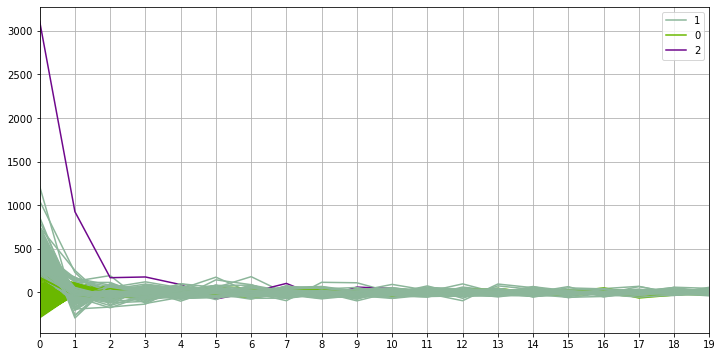

In [151]:
plt.rcParams["figure.figsize"] = [12, 6]
print('Klasteryzacja AgglomerativeClustering dla atrybutu n_clusters = 3')
pd.plotting.parallel_coordinates(Agg_X_p, 'k', axvlines=False)

## 6.2. Klasteryzacja *Birch* dla 3 skupień

In [237]:
Bir_res_p, Bir_X_p = cluster_and_score(df1_p, Birch, 3, 'n_clusters')

Klasteryzacja Birch dla atrubytu n_clusters = 3


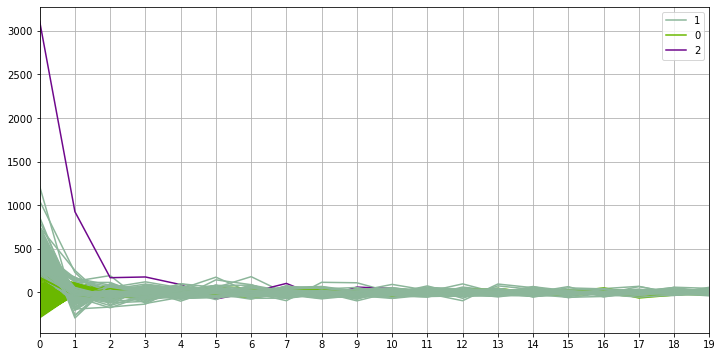

In [152]:
print('Klasteryzacja Birch dla atrubytu n_clusters = 3')
pd.plotting.parallel_coordinates(Bir_X_p, 'k', axvlines=False)

## 6.3. Klasteryzacja *MiniBatchKMeans* dla 8 skupień

In [267]:
MBKM_res_t, MBKM_X_t = cluster_and_score(df1_t, MiniBatchKMeans, 8, 'n_clusters')

Klasteryzacja MiniBatchKMeans dla atrybutu n_clusters = 8


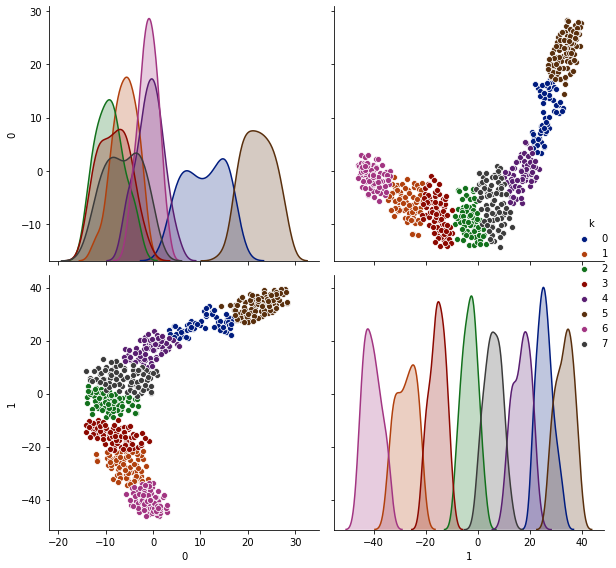

In [193]:
print('Klasteryzacja MiniBatchKMeans dla atrybutu n_clusters = 8')
plot_clusters(MBKM_X_t)

## 6.4. Klasteryzacja *Birch* dla 12 skupień

In [239]:
Bir_res_t, Bir_X_t = cluster_and_score(df1_t, Birch, 12, 'n_clusters')

Klasteryzacja Birch dla atrybutu n_clusters = 12


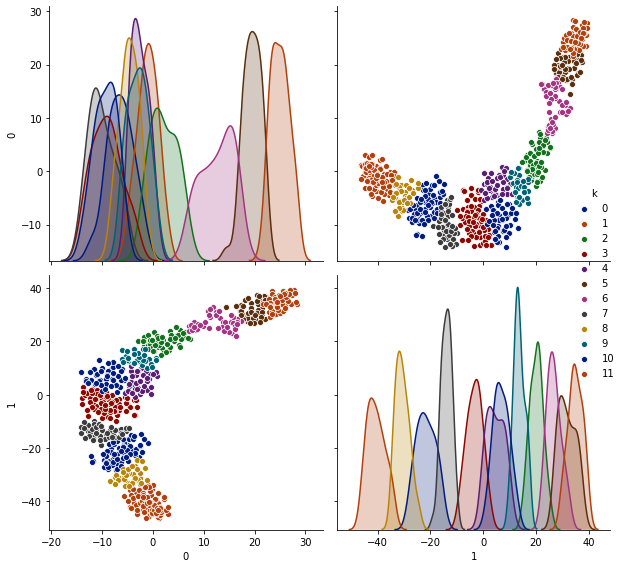

In [196]:
print('Klasteryzacja Birch dla atrybutu n_clusters = 12')
plot_clusters(Bir_X_t)

Istotnym aspektem z punktu widzenia rozważanego problemu, który pozwoli na ocenę jakości uzyskanych skupień, jest to jak uzyskana w wyniku klasteryzacji struktura koresponduje z faktycznym podziałem na rodziały.  

In [10]:
# zgrupowanie rozdziałów w książki, stosowane już przy Milestone2
clustrue = data.Title.str.split("_", expand=True)[0]
clustrue.replace({
    "BookOfProverb": "Bible",
    "BookOfEccleasiasticus": "Bible",
    "BookOfEcclesiastes": "Bible",
    "BookOfWisdom": "Bible"}, inplace=True)

In [11]:
def origclust(clu):
    clu.k = clustrue
    return clu

## Oryginalny rozkład:
t.że każdy klaster tożsamy jest z inną religią. Taka interpretacja skupień jest zgodna z propozycją uzasadnioną na etapie 2. kamienia milowego.

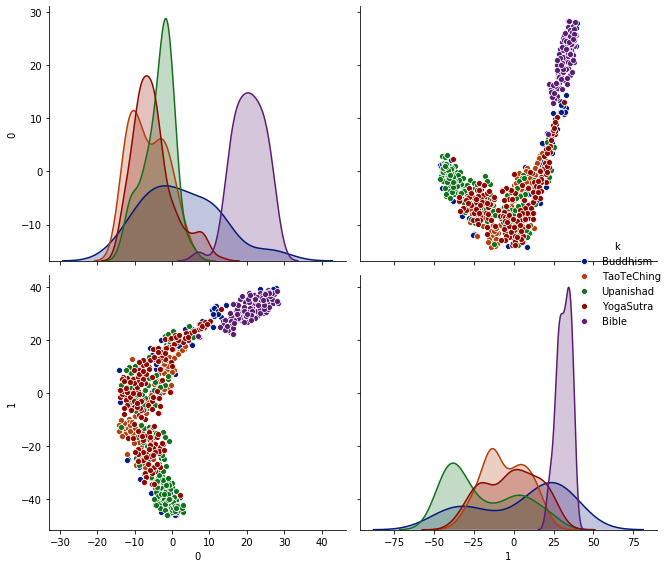

In [240]:
plot_clusters(origclust(Agg_X_t))

## Homogeniczność

In [40]:
homogeneity_score

<function sklearn.metrics.cluster._supervised.homogeneity_score(labels_true, labels_pred)>

In [41]:
tables = [Agg_X_p, Bir_X_p, MBKM_X_t, Bir_X_t]
tabnames = ["Agglometive_PCA", "Birch_PCA", "MBKM_TSNE", "Birch_TSNE"]
for i in range(4):
    print(tabnames[i] + ": \t" + str(homogeneity_score(clustrue, tables[i].k)))

Agglometive_PCA: 	0.2744022473522965
Birch_PCA: 	0.2744022473522965
MBKM_TSNE: 	0.40494869147309664
Birch_TSNE: 	0.40494869147309664


Podziały okazały się niezbyt skuteczne. Klasteryzacje uzyskane po metodzie redukcji wymiarów **t-SNE** są w 40% homogeniczne z oryginalnym podziałem na klastry, natomiast te przekształcone przez **PCA** tylko w niespełna 30%.

## Homogeniczność dla losowych etykiet

In [42]:
random_labels = [random.choice(tuple(clustrue)) for i in range(590)]

In [43]:
homogeneity_score(clustrue, random_labels)

0.014397275950453684